In [1]:
import codecs,math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Lecture de Lexique3
1. lecture dans un DF *Lexique3*
1. extraction des colonnes pertinentes *lex3*

In [2]:
nomLexiqueOrg="/Users/gilles/ownCloud/Python/phonemisation/Lexique380-UTF8.txt"
nomRepertoire="/Volumes/gilles/Transfert/Copies-iMac-GB/Python/phonemisation/"
nomLexiqueOrg=nomRepertoire+"Lexique380-UTF8.txt"
Lexique3=pd.read_csv(nomLexiqueOrg,sep="\t")

In [3]:
Lexique3.columns

Index([u'1_ortho', u'2_phon', u'3_lemme', u'4_cgram', u'5_genre', u'6_nombre',
       u'7_freqlemfilms2', u'8_freqlemlivres', u'9_freqfilms2',
       u'10_freqlivres', u'11_infover', u'12_nbhomogr', u'13_nbhomoph',
       u'14_islem', u'15_nblettres', u'16_nbphons', u'17_cvcv', u'18_p_cvcv',
       u'19_voisorth', u'20_voisphon', u'21_puorth', u'22_puphon', u'23_syll',
       u'24_nbsyll', u'25_cv-cv', u'26_orthrenv', u'27_phonrenv',
       u'28_orthosyll', u'29_cgramortho', u'30_deflem', u'31_defobs',
       u'32_old20', u'33_pld20', u'34_morphoder', u'35_nbmorph'],
      dtype='object')

In [4]:
lex3=Lexique3[["1_ortho","2_phon","3_lemme","4_cgram","5_genre","6_nombre","7_freqlemfilms2","8_freqlemlivres","9_freqfilms2","10_freqlivres","11_infover"]].copy()
Lexique3=None

In [5]:
lex3.loc[:,"7_freqlemfilms2"]=lex3.loc[:,"7_freqlemfilms2"].astype(float)
lex3.loc[:,"8_freqlemlivres"]=lex3.loc[:,"8_freqlemlivres"].astype(float)
lex3.loc[:,"9_freqfilms2"]=lex3.loc[:,"9_freqfilms2"].astype(float)
lex3.loc[:,"10_freqlivres"]=lex3.loc[:,"10_freqlivres"].astype(float)
lex3[["1_ortho","3_lemme","9_freqfilms2"]].head()

,1_ortho,3_lemme,9_freqfilms2
0,a,a,81.36
1,a,avoir,6350.91
2,a,avoir,5498.34
3,a capella,a capella,0.04
4,a cappella,a cappella,0.04


In [6]:
lex3[lex3["4_cgram"]=="VER"]["9_freqfilms2"].sum()/(lex3["9_freqfilms2"].sum())

0.21868152277211958

## Analyse de Lexique3

#### Ajout du rang pour les formes

In [7]:
lex3.loc[:,"rangFW"]=lex3.loc[:,"9_freqfilms2"].rank(ascending=False)
lex3.loc[:,"rangTW"]=lex3.loc[:,"10_freqlivres"].rank(ascending=False)
lex3.head()

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,11_infover,rangFW,rangTW
0,a,a,a,NOM,m,NaN,81.36,58.65,81.36,58.65,NaN,955.0,1297.5
1,a,a,avoir,AUX,NaN,NaN,18559.22,12800.81,6350.91,2926.69,ind:pre:3s;,22.0,46.0
2,a,a,avoir,VER,NaN,NaN,13572.40,6426.49,5498.34,1669.39,ind:pre:3s;,25.0,64.0
3,a capella,akapEla,a capella,ADV,NaN,NaN,0.04,0.07,0.04,0.07,NaN,77026.5,106149.5
4,a cappella,akapEla,a cappella,ADV,NaN,NaN,0.04,0.07,0.04,0.07,NaN,77026.5,106149.5


### Graphes Fréquence=f(Rang)

In [8]:
%matplotlib inline

#### Choix du style de plot

In [9]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("hls")
#sns.palplot(sns.color_palette("hls", 8))
#sns.palplot(sns.color_palette("husl", 8))

#### Distribution de la fréquence des formes dans Films

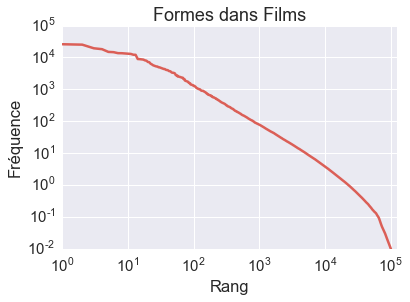

In [10]:
ax=lex3.sort_values("rangFW").set_index("rangFW")["9_freqfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes dans Films")
None

#### Distribution de la fréquence des formes dans Textes

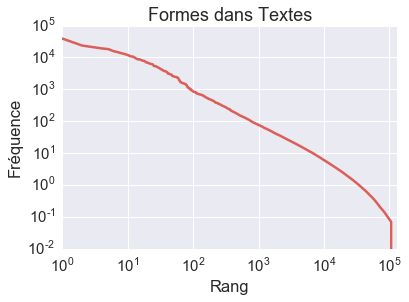

In [11]:
ax=lex3.sort_values("rangTW").set_index("rangTW")["10_freqlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes dans Textes")
None

#### Extraction des fréquences de lexèmes

In [12]:
lex3Lemmes=lex3.drop_duplicates(subset=["3_lemme","4_cgram","7_freqlemfilms2","8_freqlemlivres"]).copy()
lex3Lemmes.loc[:,"rangFL"]=lex3Lemmes.loc[:,"7_freqlemfilms2"].rank(ascending=False)
lex3Lemmes.loc[:,"rangTL"]=lex3Lemmes.loc[:,"8_freqlemlivres"].rank(ascending=False)
lex3Lemmes.head()

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,11_infover,rangFW,rangTW,rangFL,rangTL
0,a,a,a,NOM,m,NaN,81.36,58.65,81.36,58.65,NaN,955.0,1297.5,876.0,1428.5
1,a,a,avoir,AUX,NaN,NaN,18559.22,12800.81,6350.91,2926.69,ind:pre:3s;,22.0,46.0,5.0,11.0
2,a,a,avoir,VER,NaN,NaN,13572.40,6426.49,5498.34,1669.39,ind:pre:3s;,25.0,64.0,11.0,26.0
3,a capella,akapEla,a capella,ADV,NaN,NaN,0.04,0.07,0.04,0.07,NaN,77026.5,106149.5,32164.5,39703.0
4,a cappella,akapEla,a cappella,ADV,NaN,NaN,0.04,0.07,0.04,0.07,NaN,77026.5,106149.5,32164.5,39703.0


#### Distribution de la fréquence des lexèmes dans Films

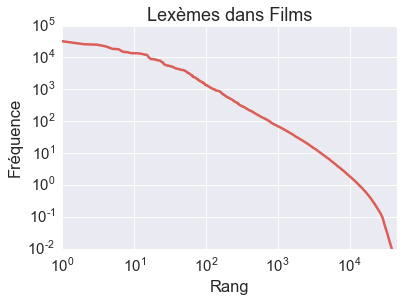

In [13]:
ax=lex3Lemmes.sort_values("rangFL").set_index("rangFL")["7_freqlemfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes dans Films")
None

#### Distribution de la fréquence des lexèmes dans Textes

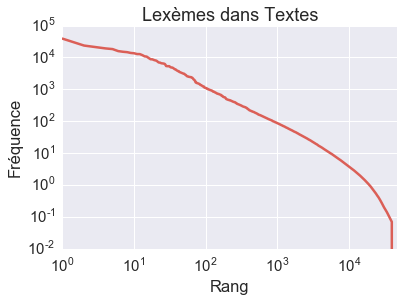

In [14]:
ax=lex3Lemmes.sort_values("rangTL").set_index("rangTL")["8_freqlemlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes dans Textes")
None

## Analyse de Verbes3

### Extraction des verbes de Lexique3

In [15]:
lex3.rename(columns={'11_infover':'lex3_11_infover'}, inplace=True)

In [16]:
verb3=lex3[lex3["4_cgram"]=="VER"]

In [17]:
verb3.loc[:,"rangFWV"]=verb3.loc[:,"9_freqfilms2"].rank(ascending=False)
verb3.loc[:,"rangTWV"]=verb3.loc[:,"10_freqlivres"].rank(ascending=False)
verb3.head()

/Users/gilles/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gilles/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,lex3_11_infover,rangFW,rangTW,rangFWV,rangTWV
2,a,a,avoir,VER,NaN,NaN,13572.40,6426.49,5498.34,1669.39,ind:pre:3s;,25.0,64.0,2.0,4.0
18,abaissa,abEsa,abaisser,VER,NaN,NaN,4.93,18.04,0.00,2.64,ind:pas:3s;,125749.0,18517.5,56608.5,6668.0
19,abaissai,abEsE,abaisser,VER,NaN,NaN,4.93,18.04,0.10,0.07,ind:pas:1s;,64548.5,106149.5,27087.5,47268.0
20,abaissaient,abEsE,abaisser,VER,NaN,NaN,4.93,18.04,0.00,0.41,ind:imp:3p;,125749.0,54431.0,56608.5,21840.0
21,abaissait,abEsE,abaisser,VER,NaN,NaN,4.93,18.04,0.02,2.50,ind:imp:3s;,88208.0,19202.0,38330.5,6954.0


### Graphes Fréquence=f(Rang)

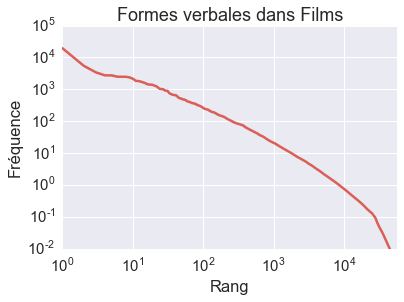

In [18]:
ax=verb3.sort_values("rangFWV").set_index("rangFWV")["9_freqfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes verbales dans Films")
None

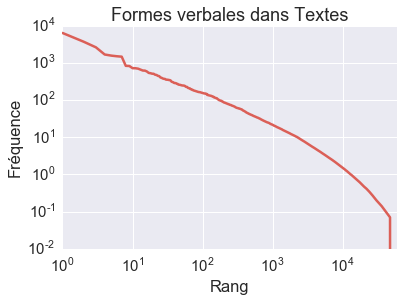

In [19]:
ax=verb3.sort_values("rangTWV").set_index("rangTWV")["10_freqlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title="Formes verbales dans Textes")
None

#### Extraction des fréquences de lexèmes

In [20]:
verb3Lemmes=verb3.drop_duplicates(subset=["3_lemme","4_cgram","7_freqlemfilms2","8_freqlemlivres"]).copy()
verb3Lemmes.loc[:,"rangFLV"]=verb3Lemmes.loc[:,"7_freqlemfilms2"].rank(ascending=False)
verb3Lemmes.loc[:,"rangTLV"]=verb3Lemmes.loc[:,"8_freqlemlivres"].rank(ascending=False)
verb3Lemmes.head()

,1_ortho,2_phon,3_lemme,4_cgram,5_genre,6_nombre,7_freqlemfilms2,8_freqlemlivres,9_freqfilms2,10_freqlivres,lex3_11_infover,rangFW,rangTW,rangFWV,rangTWV,rangFLV,rangTLV
2,a,a,avoir,VER,NaN,NaN,13572.40,6426.49,5498.34,1669.39,ind:pre:3s;,25.0,64.0,2.0,4.0,2.0,2.0
18,abaissa,abEsa,abaisser,VER,NaN,NaN,4.93,18.04,0.00,2.64,ind:pas:3s;,125749.0,18517.5,56608.5,6668.0,1295.0,915.0
51,abandonna,ab@dona,abandonner,VER,NaN,NaN,110.87,128.45,0.59,8.92,ind:pas:3s;,29868.5,7380.5,11369.0,2479.5,193.5,172.0
93,abasourdi,abazuRdi,abasourdir,VER,m,s,0.55,2.97,0.35,2.09,par:pas;,38527.0,21606.0,15094.0,7911.5,2959.0,2321.0
102,abat,aba,abattre,VER,NaN,NaN,43.47,50.61,2.15,4.93,ind:pre:3s;,14239.5,11671.5,5181.0,4056.0,381.0,440.0


#### Distribution de la fréquence des lexèmes dans Films

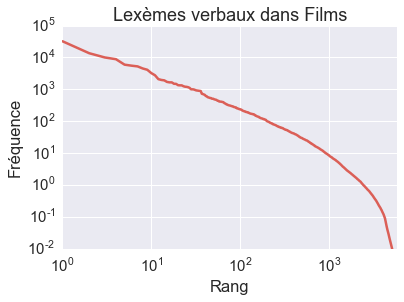

In [21]:
ax=verb3Lemmes.sort_values("rangFLV").set_index("rangFLV")["7_freqlemfilms2"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes verbaux dans Films")
None

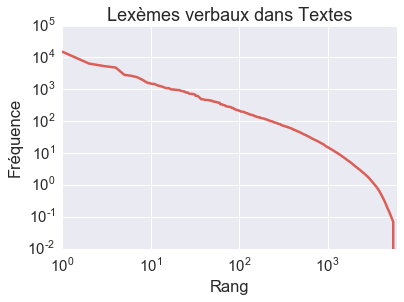

In [22]:
ax=verb3Lemmes.sort_values("rangTLV").set_index("rangTLV")["8_freqlemlivres"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Lexèmes verbaux dans Textes")
None

In [70]:
pseudoZipfFilms=verb3Lemmes.sort_values("rangFLV").set_index("rangFLV")[["7_freqlemfilms2"]]
pseudoZipfLivres=verb3Lemmes.sort_values("rangTLV").set_index("rangTLV")[["8_freqlemlivres"]]

In [71]:
pseudoZipfFilms=pseudoZipfFilms[pseudoZipfFilms["7_freqlemfilms2"]>0]
pseudoZipfFilms.drop_duplicates(inplace=True)
pseudoZipfFilms.reset_index(inplace=True)
pseudoZipfFilms

,rangFLV,7_freqlemfilms2
0,1.0,32236.50
1,2.0,13572.40
2,3.0,9992.77
3,4.0,8813.48
4,5.0,5946.15
5,6.0,5524.47
6,7.0,5249.30
7,8.0,4516.71
8,9.0,4119.43
9,10.0,3232.57


In [82]:
pseudoZipfFilms["logFreq"]=pseudoZipfFilms["7_freqlemfilms2"].apply(math.log)
pseudoZipfFilms["logRank"]=pseudoZipfFilms["rangFLV"].apply(math.log)
coefs=[1.5,1.6,1.7,1.8,1.9]
for c in coefs:
    pseudoZipfFilms[c]=pseudoZipfFilms["logFreq"]+c*pseudoZipfFilms["logRank"]

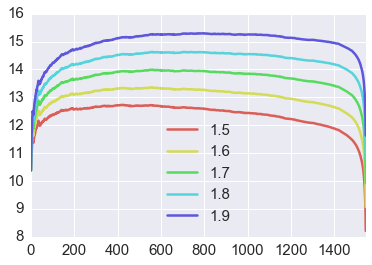

In [83]:
pseudoZipfFilms[coefs].plot()

# TESTS 
## Examen de la distribution des échantillons

In [23]:
import pickle

In [24]:
nomSample="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/Longitudinales/Longitudinal-55-T1100000-F41134.pkl"

In [26]:
with open(nomSample,"rb") as input:
    dfSample=pickle.load(input)
dfSample["rang"]=dfSample.tir1.rank(ascending=False)

ImportError: No module named indexes.base

In [ ]:
ax=dfSample.sort_values("rang").set_index("rang")["tir1"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Formes verbales")
None

In [ ]:
lexemesSample=dfSample.groupby("lexeme")[["tir1"]].sum()
lexemesSample["rang"]=lexemesSample.tir1.rank(ascending=False)

In [ ]:
ax=lexemesSample.sort_values("rang").set_index("rang")["tir1"].plot()
ax.set(xscale="log",yscale="log",xlabel="Rang",ylabel=u"Fréquence",title=u"Verbes")
None

# Projet de thèse Gauvain

In [ ]:
lex3[lex3["7_freqlemfilms2"]>=.1].groupby("3_lemme").count()

In [ ]:
for seuil in [100, 10, 1, 0.1, 0.01]:
    print "seuil",seuil
    dfFilms=lex3[lex3["7_freqlemfilms2"]>=seuil].groupby("3_lemme")
    countFilms=dfFilms.count()
    print "\tFilms"
#    print "\tTextes",lex3[(lex3["8_freqlemlivres"]>=seuil)].groupby("3_lemme").count().shape
#    print "\tLex3",lex3[(lex3["7_freqlemfilms2"]>=seuil)|(lex3["8_freqlemlivres"]>=seuil)].groupby("3_lemme").count().shape

In [ ]:
lex3.groupby("3_lemme").count()

In [14]:
lex3[(lex3["7_freqlemfilms2"]>100)].groupby("3_lemme").count().shape[0]

705

In [15]:
lex3[lex3["7_freqlemfilms2"]>=10].groupby("3_lemme").count().shape[0]

3676

In [16]:
lex3[lex3["7_freqlemfilms2"]>=1].groupby("3_lemme").count().shape[0]

12486

In [7]:
lex3[lex3["7_freqlemfilms2"]>=0.1].groupby("3_lemme").count().shape[0]

26345

In [8]:
lex3[lex3["7_freqlemfilms2"]>=0.01].groupby("3_lemme").count().shape[0]

37630

In [9]:
lex3[(lex3["8_freqlemlivres"]>100)].groupby("3_lemme").count().shape[0]

806

In [10]:
lex3[(lex3["8_freqlemlivres"]>10)].groupby("3_lemme").count().shape[0]

5147

In [11]:
lex3[(lex3["8_freqlemlivres"]>1)].groupby("3_lemme").count().shape[0]

18070

In [12]:
lex3[(lex3["8_freqlemlivres"]>0.1)].groupby("3_lemme").count().shape[0]

32888

In [13]:
lex3[(lex3["8_freqlemlivres"]>0.01)].groupby("3_lemme").count().shape[0]

40120